### Fitting for one sample

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from cmdstanpy import cmdstan_path, CmdStanModel

In [2]:
indata = pd.read_csv('intensity_table.csv')

In [3]:
mydf = pd.DataFrame({
    'I':indata.int_fit,
    'R':indata.R_calc,
    'sigma_I':indata.u_int_fit,
    'phases':indata.Phase,
    'two_th':indata.two_theta
})

mydf['IR'] = mydf.I / mydf.R
mydf['sig_IR'] = mydf['sigma_I']/mydf.R

mydf = mydf.sort_values('phases').reset_index(drop=True)

<AxesSubplot:xlabel='two_th', ylabel='IR'>

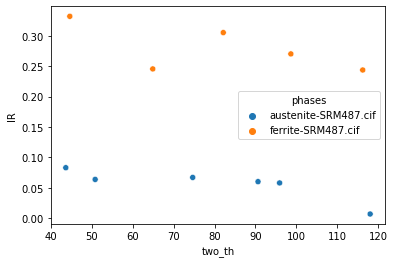

In [4]:
sns.scatterplot(data=mydf,x='two_th',y='IR',hue='phases')

In [5]:
mydf.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR
0,21716.194,261157.488,168.301,austenite-SRM487.cif,43.593,0.083154,0.000644
1,7812.145,122379.402,123.253,austenite-SRM487.cif,50.777,0.063835,0.001007
2,4734.357,70554.804,103.257,austenite-SRM487.cif,74.651,0.067102,0.001464
3,4864.974,80763.209,110.421,austenite-SRM487.cif,90.633,0.060238,0.001367
4,1368.346,23555.357,80.239,austenite-SRM487.cif,95.910,0.058091,0.003406


In [6]:
mydf['phase_id'] = 0

In [7]:
unique_phases = np.unique(mydf.phases)

In [8]:
for ii, pn in enumerate(unique_phases):
    mydf.loc[mydf['phases'] == pn,'phase_id'] = ii+1

In [9]:
mydf.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR,phase_id
0,21716.194,261157.488,168.301,austenite-SRM487.cif,43.593,0.083154,0.000644,1
1,7812.145,122379.402,123.253,austenite-SRM487.cif,50.777,0.063835,0.001007,1
2,4734.357,70554.804,103.257,austenite-SRM487.cif,74.651,0.067102,0.001464,1
3,4864.974,80763.209,110.421,austenite-SRM487.cif,90.633,0.060238,0.001367,1
4,1368.346,23555.357,80.239,austenite-SRM487.cif,95.910,0.058091,0.003406,1


### Stan starts here

In [10]:
stan_file = '../stan_files/one_sample.exe'

In [11]:
model = CmdStanModel(exe_file=stan_file)

In [12]:
os.listdir()

['.ipynb_checkpoints',
 'cif_composition_simulations.ipynb',
 'compute_structure_factor.ipynb',
 'GSASIIscript-LeBailSingleLikeGSAS.ipynb',
 'hello_world.exe',
 'hello_world.hpp',
 'hello_world.stan',
 'intensity_table.csv',
 'InteractionVolume-Plot.ipynb',
 'InteractionVolume.ipynb',
 'multiple_samples.exe',
 'multiple_samples.hpp',
 'multiple_samples.stan',
 'one_sample.exe',
 'one_sample.stan',
 'pf_uncertainty_conjugate_priors.ipynb',
 'pf_uncertainty_stan.ipynb',
 'pf_uncertainty_with_pymc3.ipynb',
 'pf_uq_math.ipynb',
 'ScatteringFactor.ipynb',
 'XRDSystem-parameters.xlsx']

In [13]:
stan_data = {
    "N":mydf.shape[0],
    "N_phases":len(np.unique(mydf.phases)),
    "Y":mydf.IR,
    "phase":mydf.phase_id,
    "prior_scale":np.std(mydf.IR),
    "prior_location":np.mean(mydf.IR)
}

stan_init = {
    "mu_phase":np.mean(mydf.IR),
    "sigma_exp":np.std(mydf.IR)
}

In [14]:
start = time.time()
fit = model.sample(data=stan_data)
end = time.time()

12:27:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:27:13 - cmdstanpy - INFO - CmdStan done processing.
12:27:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[7] is inf, but must be finite! (in 'C:/Users/dtn1/Documents/AusteniteCalc/austenitecalculator/ExampleScripts/one_sample.stan', line 18, column 4 to column 49)
Consider re-running with show_console=True if the above output is unclear!


In [15]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,20.126700,0.053828,1.716640,16.887800,20.525100,22.111400,1017.06,2530.00,1.00285
sigma_exp[1],0.034498,0.000362,0.014688,0.018657,0.030892,0.061497,1647.08,4097.22,1.00096
sigma_exp[2],0.053696,0.000707,0.026112,0.026976,0.047267,0.101501,1364.36,3393.94,1.00189
phase_mu[1],0.056773,0.000326,0.014153,0.033012,0.056951,0.080123,1889.44,4700.09,1.00031
phase_mu[2],0.278671,0.000785,0.027264,0.236563,0.278652,0.319272,1207.35,3003.37,1.00216


In [20]:
fit.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma_exp[1],sigma_exp[2],phase_mu[1],phase_mu[2]
0,19.5851,0.936395,0.440873,3.0,7.0,0.0,-16.53200,0.052745,0.062041,0.059136,0.256355
1,19.7026,0.970578,0.440873,3.0,7.0,0.0,-16.52040,0.025486,0.048638,0.038646,0.306783
2,21.4200,0.980374,0.440873,2.0,3.0,0.0,-19.22460,0.035180,0.041566,0.043983,0.278189
3,20.9846,0.978020,0.440873,3.0,7.0,0.0,-20.45170,0.047117,0.039564,0.054094,0.289911
4,21.8207,0.909990,0.440873,3.0,7.0,0.0,-18.11170,0.036636,0.033065,0.067623,0.280077
...,...,...,...,...,...,...,...,...,...,...,...
3995,15.2251,0.149093,0.373115,2.0,3.0,0.0,-9.08596,0.023517,0.104663,0.045975,0.160493
3996,14.3044,0.958058,0.373115,4.0,15.0,0.0,-11.79920,0.028051,0.085358,0.040310,0.165156
3997,14.6054,0.859426,0.373115,2.0,3.0,0.0,-11.39310,0.024395,0.095143,0.040713,0.166351
3998,10.4295,0.941221,0.373115,4.0,23.0,0.0,-8.69812,0.037734,0.068258,0.043394,0.416560


In [26]:
import plotly.express as px
import re

In [96]:
def generate_pf_plot(fit):
    mcmc_df = fit.draws_pd()
    mu_res = np.array(mcmc_df.loc[:,mcmc_df.columns.str.contains('phase_mu')])
    n_phase = mu_res.shape[1]
    
    row_sums = np.sum(mu_res,axis=1)
    mu_res_norm = mu_res

    for ii in range(n_phase):
        mu_res_norm[:,ii] = mu_res_norm[:,ii]/row_sums
        
    out_df = [None]*n_phase

    quantiles = np.zeros((n_phase,2))

    for ii in range(n_phase):

        out_df[ii] = pd.DataFrame({
            'mu_samps':mu_res_norm[:,ii],
            'phase':unique_phases[ii]
        })

        quantiles[ii,:] = np.quantile(mu_res_norm[:,ii],(.025,.975))

    out_df = pd.concat(out_df,axis=0).reset_index(drop=True)
    
    quantiles = quantiles.flatten()
    
    fig = px.histogram(out_df,x='mu_samps',color='phase',opacity=.75)
    
    for ii in range(len(quantiles)):
        fig.add_vline(quantiles[ii],opacity=.5,line_dash='dash')
    #fig.show()
    
    return fig

In [97]:
fig = generate_pf_plot(fit)
fig.show()

### Multiple samples

In [98]:
multiple_df = pd.concat((mydf.copy(),mydf.copy(),mydf.copy())).reset_index(drop=True)
multiple_df['sample_id'] = np.repeat((0,1,2),11)
np.random.seed(123)

for ii in range(3):
    multiple_df.loc[multiple_df['sample_id']==ii,'I'] = multiple_df['I'].loc[multiple_df['sample_id']==ii]*(1+ii/2)
    
multiple_df['I'] = multiple_df['I'] + np.random.normal(0,multiple_df['I']/10,multiple_df.shape[0])
multiple_df['IR'] = multiple_df['I']/multiple_df['R']

In [99]:
multiple_df['sample_id'] = multiple_df['sample_id'] + 1

In [100]:
multiple_df.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR,phase_id,sample_id
0,19358.617521,261157.488,168.301,austenite-SRM487.cif,43.593,0.074126,0.000644,1,1
1,8591.285724,122379.402,123.253,austenite-SRM487.cif,50.777,0.070202,0.001007,1,1
2,4868.329123,70554.804,103.257,austenite-SRM487.cif,74.651,0.069001,0.001464,1,1
3,4132.165538,80763.209,110.421,austenite-SRM487.cif,90.633,0.051164,0.001367,1,1
4,1289.173466,23555.357,80.239,austenite-SRM487.cif,95.910,0.054730,0.003406,1,1


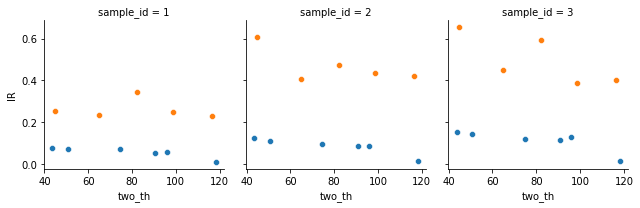

In [101]:
#multiple_df
g = sns.FacetGrid(multiple_df,col='sample_id',hue='phases')
g.map(sns.scatterplot,'two_th','IR')

### Stan starts here

In [102]:
stan_file = 'multiple_samples.stan'

In [103]:
model = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:found newer exe file, not recompiling


In [104]:
stan_data = {
    "N":multiple_df.shape[0],
    "N_samples":len(np.unique(multiple_df.sample_id)),
    "N_phases":len(np.unique(multiple_df.phases)),
    "Y":multiple_df.IR,
    "phase":multiple_df.phase_id,
    "group":multiple_df.sample_id,
    "prior_scale":np.std(multiple_df.IR),
    "prior_location":np.mean(multiple_df.IR)
}

stan_init = {
    "mu_phase":np.mean(multiple_df.IR),
    "sigma_exp":np.std(multiple_df.IR),
    "sigma_sample":np.std(multiple_df.IR),
    "group_effect":0
}

In [105]:
start = time.time()
fit = model.sample(data=stan_data,
                   #inits=stan_init,
                   chains=4,
                   iter_warmup=1000, 
                   iter_sampling=1000)
end = time.time()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [106]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,68.000,0.07700,2.200,64.000,69.0000,71.000,840.0,1400.0,1.0
sigma_sample,0.067,0.00200,0.053,0.016,0.0520,0.160,720.0,1200.0,1.0
sigma_exp[1],0.043,0.00023,0.009,0.031,0.0420,0.060,1564.0,2572.0,1.0
sigma_exp[2],0.130,0.00062,0.027,0.090,0.1200,0.180,1812.0,2980.0,1.0
phase_mu[1],0.088,0.00200,0.037,0.029,0.0850,0.160,325.0,534.0,1.0
phase_mu[2],0.410,0.00220,0.049,0.340,0.4100,0.500,488.0,802.0,1.0
group_effect[1],-0.039,0.00210,0.039,-0.110,-0.0330,0.017,337.0,554.0,1.0
group_effect[2],0.002,0.00200,0.037,-0.068,0.0035,0.061,355.0,585.0,1.0
group_effect[3],0.024,0.00210,0.038,-0.043,0.0240,0.085,336.0,553.0,1.0


In [47]:
end - start

1.2190110683441162

In [107]:
generate_pf_plot(fit)